# Fitness MCMC Documentation Notebook

In [28]:
#Standard Imports
import numpy as np
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

In [29]:
#Imports from fitness mcmc package 
import fitness_mcmc
import fitness_mcmc.data_io as io 
import fitness_mcmc.fitness_mcmc as m

## Overview 

Mapping genotypes to phenotypes is critical to uncovering hidden biological mechanisms and functions. Distilling raw genotypic data to summary statistics allows for computational simplicity while still capturing the complexities within the original data. We want to infer ***fitness*** - a summary statistic that represents the survival rate for each genotype - given a dataset of generational survival counts i.e. how many organisms survive after a generation. This inference can give us a single quantitative value representing a single genotype thereby reducing our data overhead. 

## Statistical Model

The generative model to infer fitnesses from genotypes assumes an exponential dependence of fitness on data. The prior for fitnesses is assumed to be flat. 

prior: $$s \sim \text{flat}('fitnesses') $$

The likelihoods take a poisson function since there is noise from sampling from generation to generation. The function described by $$\lambda$$ showcases the exponential model. 

likelihood: $$f \sim \text{poisson}(\lambda)$$
where $$\lambda_i \sim \frac {f0_i * exp(s_i * t)} {\sum_{i} f0_i * exp(s_i * t)}$$


posterior: 
$$p(s \mid D,M,I) \propto p(s \mid M,I)p(D\mid M,I,s)$$

### Let's look at the data

The function `load_data` in `data_io.py` returns a pandas dataframe of the raw data (i.e. `data`), a numpy array of time generations (i.e. `time`), and a numpy array of arrays of ordered frequencies (i.e. `ordered_frequencies`) where the order is determined by the number of counts. 

In [30]:
"""
Loading data and looking at the first 40 ordered genotypes. 
"""
data, time, ordered_frequencies  = io.load_data('filtered_counts_ypd_temp_30.txt')
data

,BC,5,10,25,40,45
0,GGGAGACCGCCGCGGG_AGACGACGGGTATTAC,1682,1101,416,112,41
1,TTATGAAGTAGTTGTA_AATTTTTTTGCCATTC,463,169,50,3,7
2,ATACAATCATTCATAG_CCCGTGAGCTGAGCCG,1375,322,148,120,36
3,GGGTAATCACGCCGAA_GGCAACTAATAATATA,639,256,151,64,31
4,TAGAACCGGTTAAAAA_TGGTAGCTGGACGACA,917,231,48,5,15
...,...,...,...,...,...,...
718,CCAAACGCCGTACTAT_CGTCTAGCATAAAGCA,231,106,21,2,0
719,ACCGCCTGGTCACCAG_TTCGTTACTGCCGGGG,278,111,9,5,0
720,TACAACGGATTGGGAA_TTCACATCTGGTACCA,833,181,89,43,47
721,ACGCACCAAGCCGGGA_CCGGGCGATCCACGAA,2916,1559,334,98,47


The first column `5,10,25,40,45` shows the generations where genotypes are sampled. The values under the generation represent counts - the number of each genotype alive. The frequency metadata is calculated by normalizing the counts per generation sample and then they are ordered by genotype with the most total counts across all generations. That is what ordered frequencies represents. 

## Doing some inference on subset of real data

We take our fitness model object and give it our ordered frequencies, metadata generated earlier, and the time generations. Calling `find_MAP()`, we and then plotting we see how well our reconstructed model compares to the actual data in a linear plot of frequencies vs generations. 

In [31]:
fitness_model = m.Fitness_Model(ordered_frequencies[0:40],time)
fitness_model.find_MAP()

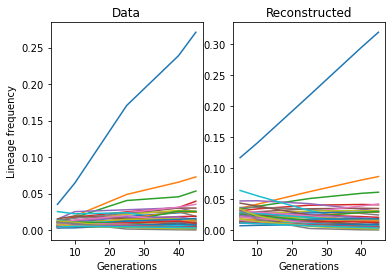

In [32]:
fitness_model.plot_MAP_estimate(type = "lin")

## Doing inference on simulated data  

We compare the fitted functions with the simulated data. 

In [33]:
#simulated data 
data, time, ordered_frequencies = io.load_data("fitness_mcmc/simulated_data.txt")
simulated_model = m.Fitness_Model(ordered_frequencies,time)

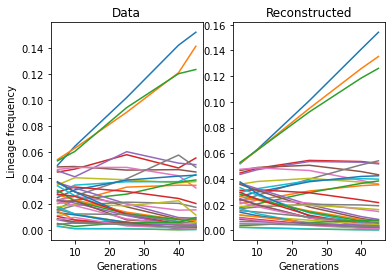

In [34]:
simulated_model.find_MAP()
simulated_model.plot_MAP_estimate(type = "lin")

## Doing inference with MCMC on real data

Completing MCMC to generate quantitative understanding of the uncerainities on our estimated fitness and intial frequency values. (Using a subset of our real data) 

In [35]:
fitness_model = m.Fitness_Model(ordered_frequencies[0:40],time)
fitness_model.find_MAP()
fitness_model.mcmc_sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [f0, s]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 79 seconds.
The acceptance probability does not match the target. It is 0.9316908419003286, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9498071590714164, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9059168426500893, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9932386599459078, but should be close to 0.8. Try to increase the number of tuning steps.


/Users/pavelzhelnin/anaconda3/envs/phys201/lib/python3.9/site-packages/arviz/plots/plot_utils.py:490: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (78) in plot_posterior, generating only 40 plots
  warnings.warn(


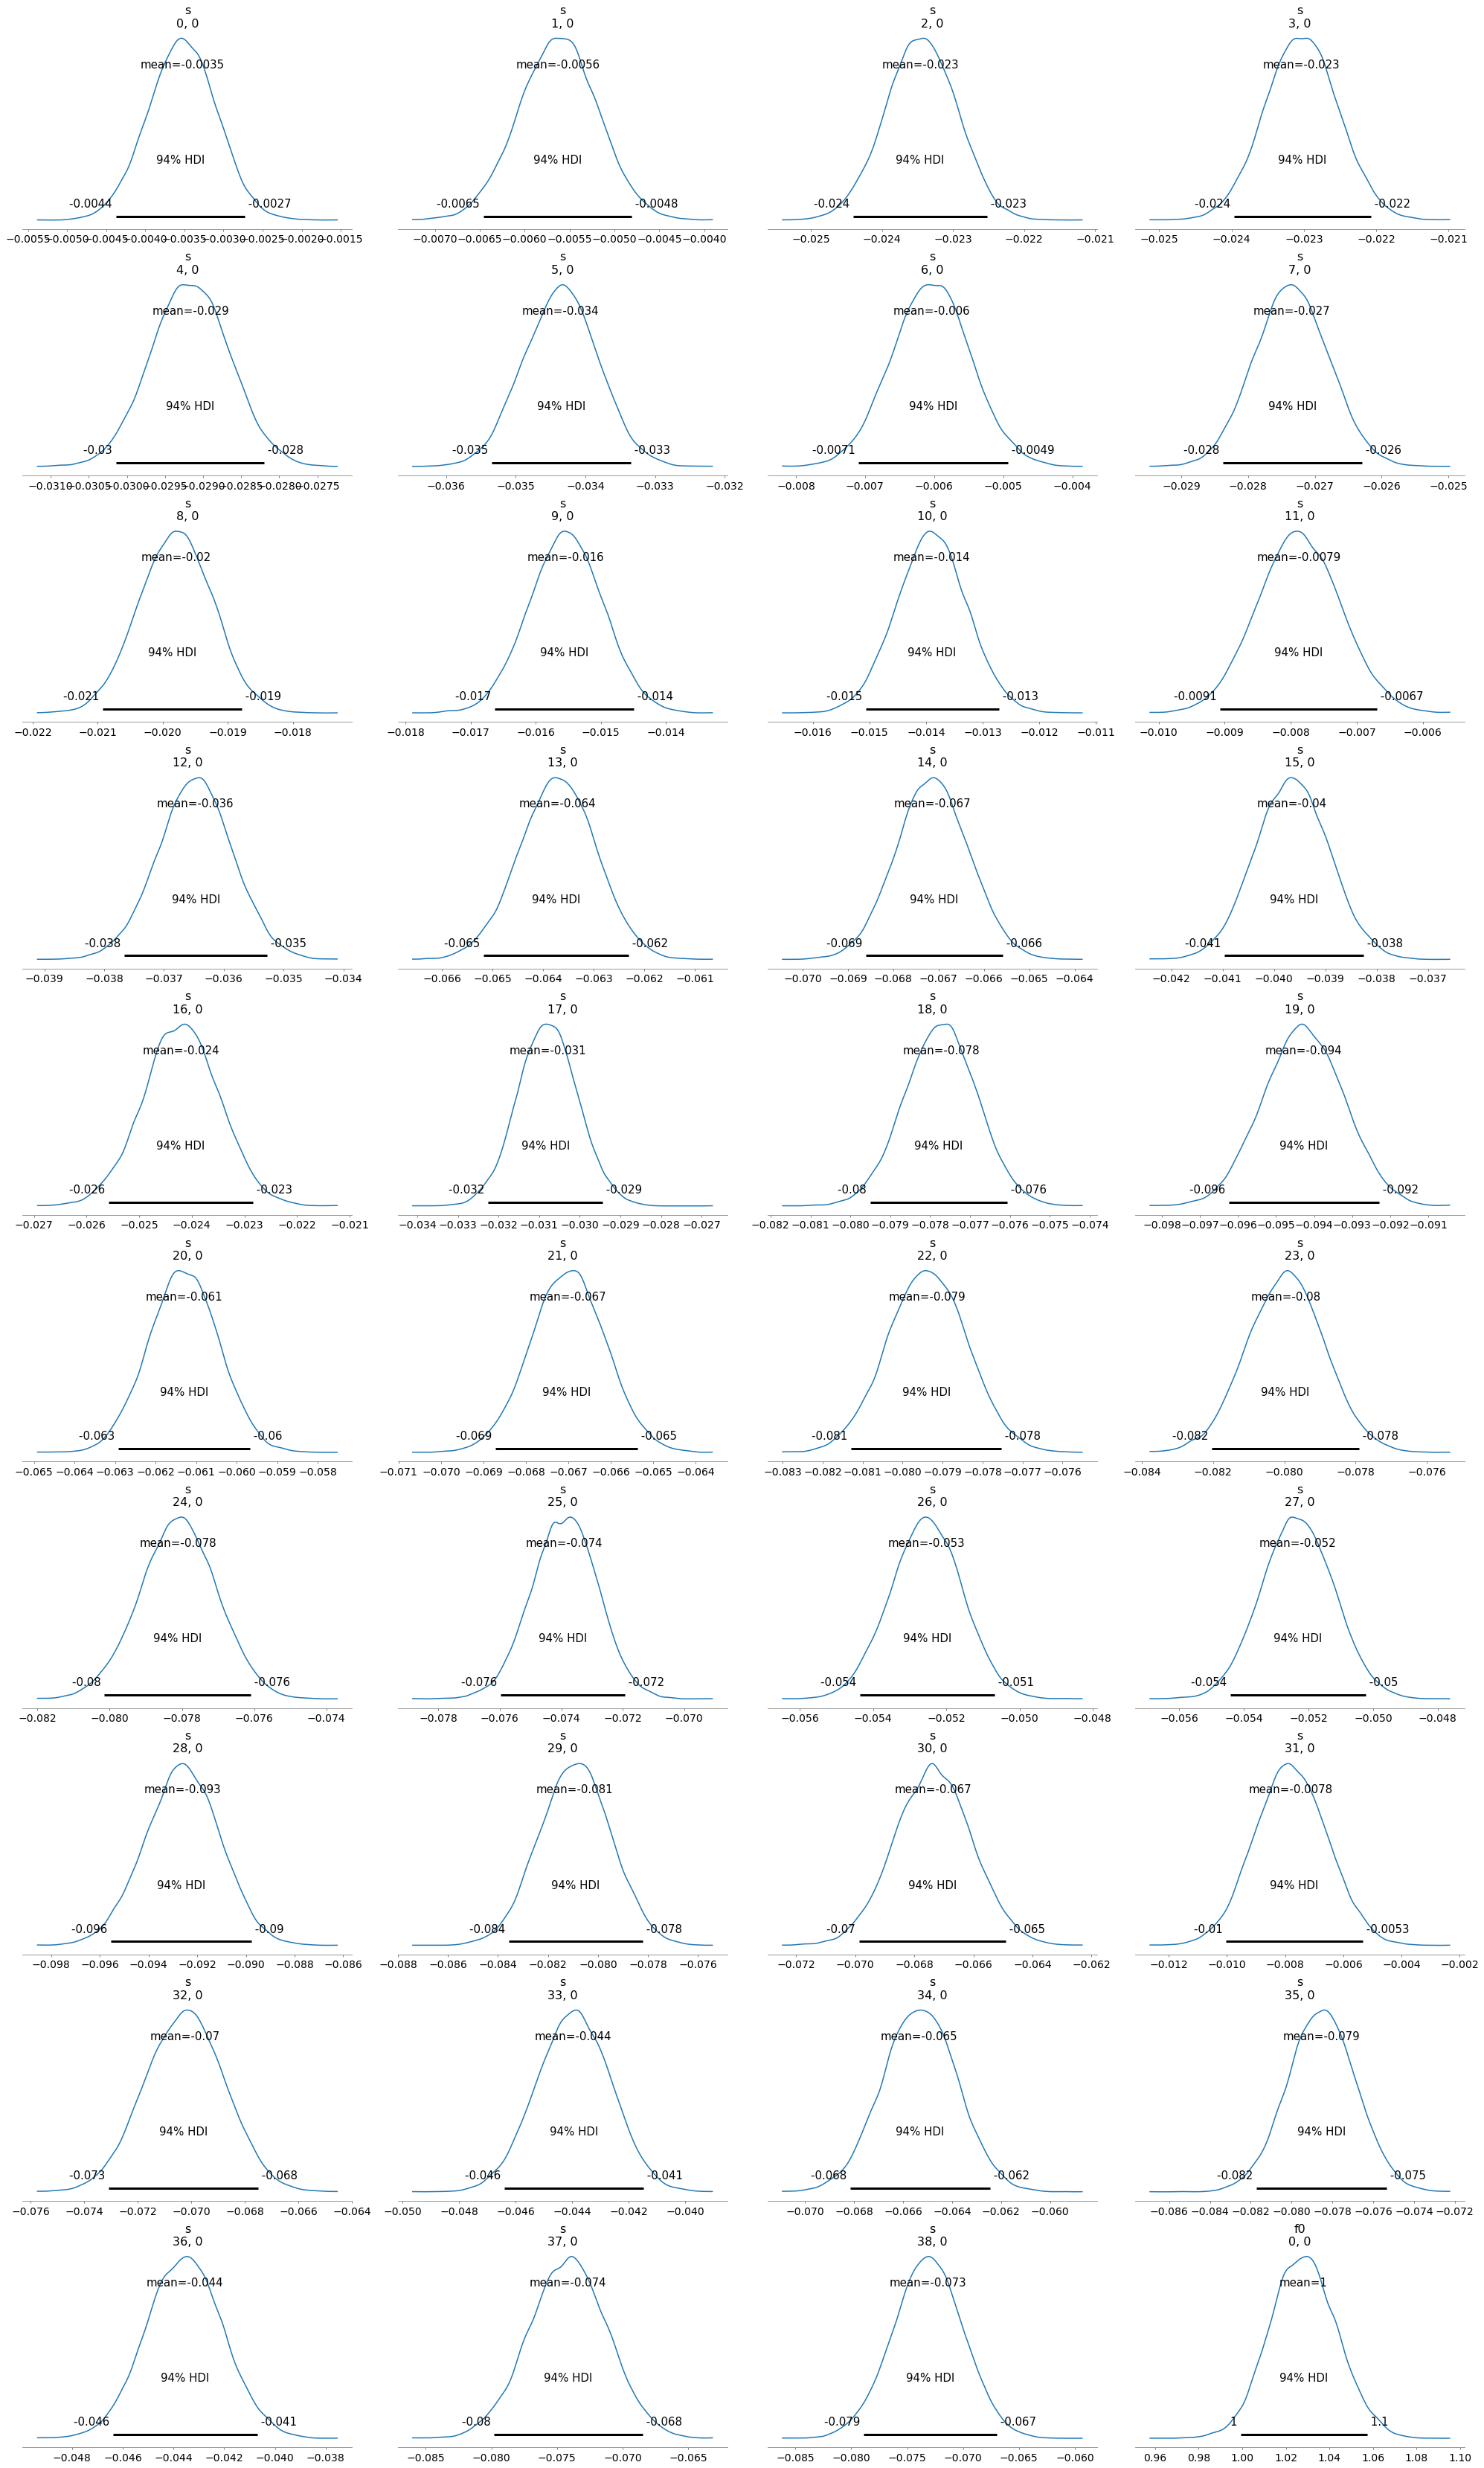

In [36]:
fitness_model.plot_mcmc_posterior()